## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Урок 4. Generative adversarial networks (GAN): генеративные сети

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from torchvision.utils import save_image, make_grid

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


**1. Обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:**
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Построить графики

In [5]:
# Функция linspace() возвращает одномерный массив из указанного количества элементов, значения которых равномерно распределенны внутри заданного интервала.
x = np.linspace(1, 30, 1000)
def func_y(x):
    return np.sin(x)/x - x/10
# print("Func_y:", func_y(x))    

In [6]:
dataset = func_y(x)

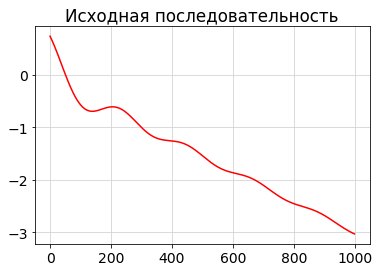

In [7]:
plt.plot(dataset, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

### Preparing the Training Data

In [8]:
class build_dataset(Dataset):
    def __init__(self, d_border, u_border, point_number):
        x = np.linspace(d_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [9]:
dataset = build_dataset(1, 30, 1000)

In [10]:
batch_size = 16

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),
                                                                      len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

### Implementing the Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [12]:
discriminator = Discriminator().to(device)

### Implementing the Generator

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [14]:
generator = Generator().to(device)

### Training the Models

In [15]:
lr = 0.0001

b1 = 0.5
b2 = 0.999

sample_interval = 50

loss_function = nn.BCELoss()

In [16]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [17]:
d_loss_history = []
g_loss_history = []

In [18]:
idx = torch.randperm(16)
idx

tensor([ 1,  3,  8,  0, 13, 14, 11,  7,  9, 10,  6,  4, 15, 12,  5,  2])

In [19]:
for epoch in range(1):
    for i, (number, labels) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([24.0490,  2.5676, 22.5686, 23.6717, 29.5355, 23.9329,  2.0741, 23.6136,
        12.6987,  8.4024,  1.2903,  1.3483, 24.2523, 17.6046,  9.5345, 14.0631],
       device='cuda:0')
z: tensor([[14.0631],
        [22.5686],
        [ 2.0741],
        [ 2.5676],
        [23.6717],
        [29.5355],
        [24.2523],
        [ 8.4024],
        [ 1.3483],
        [23.9329],
        [ 1.2903],
        [23.6136],
        [17.6046],
        [12.6987],
        [ 9.5345],
        [24.0490]], device='cuda:0')
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.694427] [G loss: 0.695317]


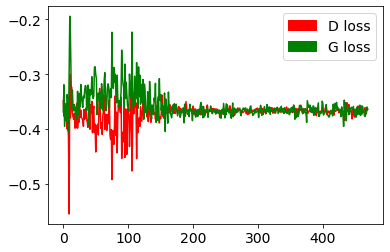

In [20]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)
#         valid = valid.detach().numpy()

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = loss_function(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = loss_function(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = loss_function(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [21]:
torch.save(generator.state_dict(), "series_gan.pth")

In [22]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [23]:
x =  np.linspace(1, 30, 1000)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.cuda.FloatTensor'

In [24]:
gen_numbers = generator_r(xt.view(len(x), 1))

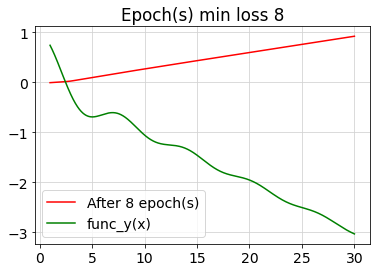

In [25]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'r', label=f"After {ep_loss} epoch(s)")
plt.plot(x, func_y(x), 'g', label=f"func_y(x)")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Epoch(s) min loss {ep_loss}')
plt.show()

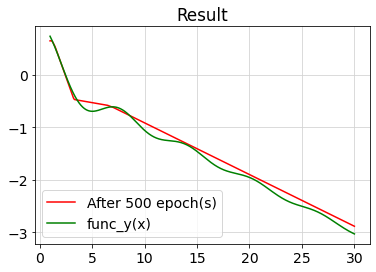

In [26]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'r', label=f"After {n_epochs} epoch(s)")
plt.plot(x, func_y(x), 'g', label=f"func_y(x)")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Result' )
plt.show()

In [27]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [28]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

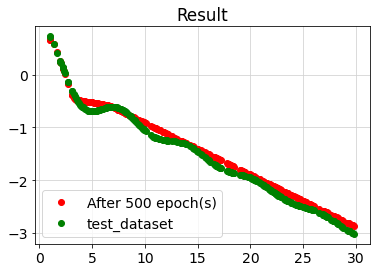

In [29]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"After {n_epochs} epoch(s)")
plt.plot(x_test, y_test, 'go', label=f"test_dataset")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Result' )
plt.show()